```bash
jupyter nbconvert pldi_2023_presentation.ipynb --to slides
```

# `egglog` in Python...

*EGRAPHS Workshop - PLDI '23*<br>
*Saul Shanabrook*

Thank you

1. ...for existing `egglog` users.
2. ...for Python data science libraries.

* Tutorial earlier
* First is more complete
* Second is more aspirational, more motivating
    * Improve collaboration between open source data science libraries
    * Dealing with abstraction

In [1]:
from __future__ import annotations
from egglog import *

## How does it work?

* Will show how some examples translate

### Sorts, expressions, and functions

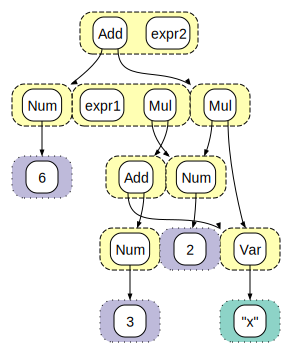

In [2]:
%%egglog graph
(datatype Math
  (Num i64)
  (Var String)
  (Add Math Math)
  (Mul Math Math))

(define expr1 (Mul (Num 2) (Add (Var "x") (Num 3))))
(define expr2 (Add (Num 6) (Mul (Num 2) (Var "x"))))

* User defined sorts
* Expressions
    * expr1 and expr2 in their own e-classes, we haven't ran any rules
* `%%egglog` magic, Writing egglog in Notebook, graphs, output inline.

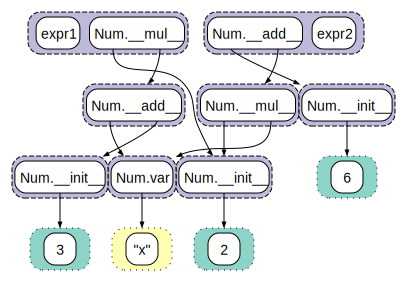

In [3]:
egraph = EGraph()

@egraph.class_
class Num(BaseExpr):
    
    @classmethod
    def var(cls, name: StringLike) -> Num: ...
    def __init__(self, value: i64Like) -> None: ...
    def __add__(self, other: Num) -> Num:  ...
    def __mul__(self, other: Num) -> Num:  ...

expr1 = egraph.define("expr1", Num(2) * (Num.var("x") + Num(3)))
expr2 = egraph.define("expr2", Num(6) + Num(2) * Num.var("x"))
egraph

* Re-use existing Python class and functions
    * Humans and computers to understand the typing semantics
    * Humans read `__init__` and `__add__`.
    * Static type checkers. `Num("String")` it won't work.
    * Static type checking drives much of the API design of the library
* Operator overloading support infix operators
* Names generated based on classes
    * Same operator on different types compile to different function with different signature

### Rewrite rules and checks

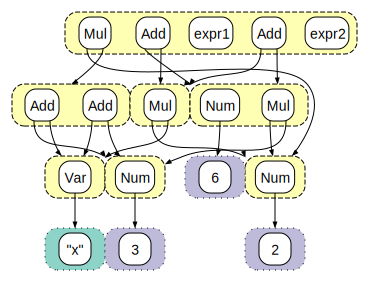

In [4]:
%%egglog graph continue
(rewrite (Add a b)
         (Add b a))
(rewrite (Mul a (Add b c))
         (Add (Mul a b) (Mul a c)))
(rewrite (Add (Num a) (Num b))
         (Num (+ a b)))
(rewrite (Mul (Num a) (Num b))
         (Num (* a b)))

(run 10)
(check (= expr1 expr2))

* See equivalent, in same e-class now

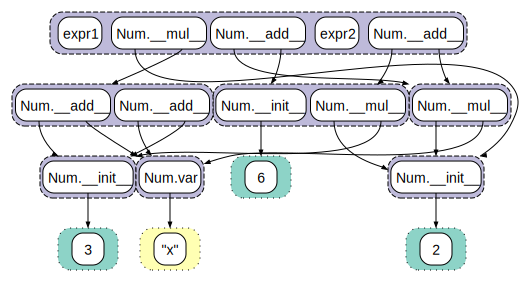

In [5]:
@egraph.register
def _(a: Num, b: Num, c: Num, i: i64, j: i64):
    yield rewrite(a + b).to(b + a)
    yield rewrite(a * (b + c)).to((a * b) + (a * c))
    yield rewrite(Num(i) + Num(j)).to(Num(i + j))
    yield rewrite(Num(i) * Num(j)).to(Num(i * j))

egraph.run(10)
egraph.check(eq(expr1).to(expr2))
egraph

* Similar in Python, rewrite rules, run, check
* Notice that all vars need types, unlike inferred in egglog
    * Both for static type checkers to verify
    * And for runtime to know what methods

### Extraction

In [6]:
%%egglog continue output
(extract expr1)


Extracted with cost 8: (Add (Mul (Num 2) (Var "x")) (Num 6))


* Extract lowest cost expr

In [7]:
egraph.extract(expr1)

(Num(2) * Num.var("x")) + Num(6)

* get back expr object
* Str representation is Python syntax

### Multipart Rules

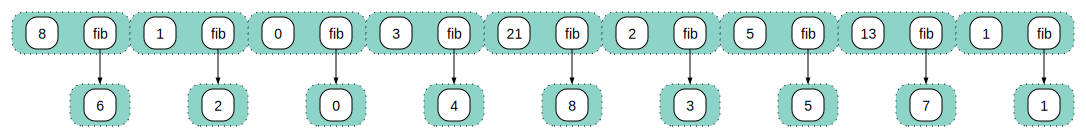

In [8]:
%%egglog graph
(function fib (i64) i64)

(set (fib 0) 0)
(set (fib 1) 1)
(rule ((= f0 (fib x))
       (= f1 (fib (+ x 1))))
      ((set (fib (+ x 2)) (+ f0 f1))))

(run 7)
(check (= (fib 7) 13))

* Rule that depend on facts and execute actions

In [9]:
fib_egraph = EGraph()

@fib_egraph.function
def fib(x: i64Like) -> i64: ...

@fib_egraph.register
def _(f0: i64, f1: i64, x: i64):
    yield set_(fib(0)).to(i64(1))
    yield set_(fib(1)).to(i64(1))
    yield rule(
        eq(f0).to(fib(x)),
        eq(f1).to(fib(x + 1)),
    ).then(
        set_(fib(x + 2)).to(f0 + f1)
    )

fib_egraph.run(7)
fib_egraph.check(eq(fib(7)).to(i64(21)))

* `set_` and and `eq` both type safe. Required builder syntax

### Include & Modules

In [10]:
%%writefile path.egg
(relation path (i64 i64))
(relation edge (i64 i64))

(rule ((edge x y))
      ((path x y)))

(rule ((path x y) (edge y z))
      ((path x z)))

Overwriting path.egg


In [11]:
%%egglog
(include "path.egg")
(edge 1 2)
(edge 2 3)
(edge 3 4)
(run 3)
(check (path 1 3))

* Include another file for re-useability

In [12]:
mod = Module()
path = mod.relation("path", i64, i64)
edge = mod.relation("edge", i64, i64)

@mod.register
def _(x: i64, y: i64, z: i64):
    yield rule(edge(x, y)).then(path(x, y))
    yield rule(path(x, y), edge(y, z)).then(path(x, z))

* Modules same in Python
* Supports defining rules, etc, but doesn't actually run them, just builds up commands

In [13]:
egraph = EGraph([mod])
egraph.register(
    edge(1, 2),
    edge(2, 3),
    edge(3, 4)
)
egraph.run(3)
egraph.check(path(1, 3))

* Then when we depend on them, it will run those commands first.
* Allows distribution of code and others to re-use it, using existing Python import mechanisms.

## But what is it good for?

### Other Python EGraph Libraries
* [`riswords/quiche`](https://github.com/riswords/quiche): Optimizing Python ASTs
* [`egraphs-good/snake-egg`](https://github.com/egraphs-good/snake-egg): Generic bindings for `egg`, can bring any Python objects as expressions.
* [EGraph library added to `ibis`](https://github.com/ibis-project/ibis/pull/5781): Conversions between dataframe syntax and SQL dialects

### Why another e-graph Python library?

* Follow along with research being done in `egglog` (e.g. multi-pattern matching)
* Constrained type system could support **decentralized interopability and composition between data science libraries**
    * _language, experimentation, power dynamics, accessability_

* Started with `snake-egg`
* Didn't want to re-invent the wheel, stay abreast of recent developments and research
* Second piece that interests me
    * Unlike `egg` there are some builtin sorts, and can build user defined sorts on top of those
    * No host language conditions or data structures
    * Helps with optimization, more constrained
    * -> De-centers algorithms based on value, move to based on type. Everything becomes an interface.
    * Social dynamics, goal is ability to inovate and experiment, while still supporting existing use cases
        * New dataframe library comes out, supporting custom hardware. How dow we use it without rewriting code?
        * How do we have healthy ecosystem within these tools? Power
        * If it's too hard, encourages centralized monopolistic actors to step in provide one stop shop solutions for users.
    * Active problem in the community, with things like trying to standardize on interop.
    * Before getting too abstract, let's go to an example

### A story about Arrays

* This is one path through a huge maze of use cases.
* Does not represent one killer example, but is an area I am familar with based on my previous work

#### 1. Someone makes an NDArray library...

In [14]:
ndarray_mod = Module()
...

In [15]:
@ndarray_mod.class_
class Value(BaseExpr):
    def __init__(self, v: i64Like) -> None:
        ...

    def __mul__(self, other: Value) -> Value:
        ...

    def __add__(self, other: Value) -> Value:
        ...


i, j = vars_("i j", i64)
ndarray_mod.register(
    rewrite(Value(i) * Value(j)).to(Value(i * j)),
    rewrite(Value(i) + Value(j)).to(Value(i + j)),
)


@ndarray_mod.class_
class Values(BaseExpr):
    def __init__(self, v: Vec[Value]) -> None:
        ...

    def __getitem__(self, idx: Value) -> Value:
        ...

    def length(self) -> Value:
        ...

    def concat(self, other: Values) -> Values:
        ...


@ndarray_mod.register
def _values(vs: Vec[Value], other: Vec[Value]):
    yield rewrite(Values(vs)[Value(i)]).to(vs[i])
    yield rewrite(Values(vs).length()).to(Value(vs.length()))
    yield rewrite(Values(vs).concat(Values(other))).to(Values(vs.append(other)))

In [16]:
@ndarray_mod.class_
class NDArray(BaseExpr):
    def __getitem__(self, idx: Values) -> Value: ...
    def shape(self) -> Values: ...

@ndarray_mod.function
def arange(n: Value) -> NDArray: ...

* Basic
* One function, range, get shape and index into array
* Very different from existing paradigms in Python... Inheritance, multi-dispatch, dunder protocols.
    * Entirely open protocol.
    * Anyone else could define ways to create arrays
    * About mathematical definition really. This is from M

_"A Mathematics of Arrays"  - 1988 - Lenore Mullin's dissertation_

In [17]:
@ndarray_mod.register
def _(n: Value, idx: Values):
    yield rewrite(arange(n).shape()).to(Values(Vec(n)))
    yield rewrite(arange(n)[idx]).to(idx[Value(0)])

* Rules to compute shape and index into arange. 

In [18]:
egraph = EGraph([ndarray_mod])
ten = arange(Value(10))
egraph.simplify(ten.shape(), 10)

Values(Vec.empty().push(Value(10)))

In [19]:
egraph.simplify(ten[Values(Vec(Value(7)))], 10)

Value(7)

* Any user can try it now

#### 2. Someone else decides to implement a cross product library

In [20]:
cross_mod = Module([ndarray_mod])

@cross_mod.function
def cross(l: NDArray, r: NDArray) -> NDArray: ...

@cross_mod.register
def _cross(l: NDArray, r: NDArray, idx: Values):
    yield rewrite(cross(l, r).shape()).to(l.shape().concat(r.shape()))
    yield rewrite(cross(l, r)[idx]).to(l[idx] * r[idx])

* Someone decides to add some functionality
* Multiplicative cross product
* Shape is concatation, index is product of each matrix at that index
* Mathematical definition

In [21]:
egraph = EGraph([cross_mod])
egraph.simplify(cross(arange(Value(10)), arange(Value(11))).shape(), 10)

Values(Vec.empty().push(Value(11)).push(Value(10)))

#### 3. I write my wonderful data science application using it

In [22]:
def my_special_app(x: Value) -> Value:
    return cross(arange(x), arange(x))[Values(Vec(x))] 

egraph = EGraph([cross_mod])

egraph.simplify(my_special_app(Value(10)), 10)

Value(100)

* Different person installs cross module
* Implements application using their complicated algorithm

.... but its too slow...

In [23]:
for i in range(100):
    egraph.simplify(my_special_app(Value(i)), 10)

* Too slow in inner loop
* Is there a way we could optimize it

#### 4. Someone else writes a library for delayed execution

In [24]:
py_mod = Module([ndarray_mod])

@py_mod.function
def py_value(s: StringLike) -> Value: ...

...

Ellipsis

* While this is happening, someone else, based on the original module, wrote a different execution semantics
* Builds up expression string instead of trying to evaluate eagerly

In [25]:
@py_mod.register
def _py_value(l: String, r: String):
    yield rewrite(py_value(l) + py_value(r)).to(py_value(join(l, " + ", r)))
    yield rewrite(py_value(l) * py_value(r)).to(py_value(join(l, " * ", r)))


@py_mod.function
def py_values(s: StringLike) -> Values:
    ...


@py_mod.register
def _py_values(l: String, r: String):
    yield rewrite(py_values(l)[py_value(r)]).to(py_value(join(l, "[", r, "]")))
    yield rewrite(py_values(l).length()).to(py_value(join("len(", l, ")")))
    yield rewrite(py_values(l).concat(py_values(r))).to(py_values(join(l, " + ", r)))



@py_mod.function
def py_ndarray(s: StringLike) -> NDArray:
    ...


@py_mod.register
def _py_ndarray(l: String, r: String):
    yield rewrite(py_ndarray(l)[py_values(r)]).to(py_value(join(l, "[", r, "]")))
    yield rewrite(py_ndarray(l).shape()).to(py_values(join(l, ".shape")))
    yield rewrite(arange(py_value(l))).to(py_ndarray(join("np.arange(", l, ")")))


#### 5. I can use it jit compile my application!

In [26]:
egraph = EGraph([cross_mod, py_mod])
egraph.simplify(my_special_app(py_value("x")), 10)

py_value("x * x")

* I pull in third party library
* Add it to my e-graph
* Now I can compile lazily
* py_mod never needed to know about cross product, works with it

... and add support for jit compilation for the other library I am using, without changing either library:

In [27]:
@egraph.register
def _(l: String, r: String):
    yield rewrite(cross(py_ndarray(l), py_ndarray(r))).to(py_ndarray(join("np.multiply.outer(", l, ", ", r, ")")))

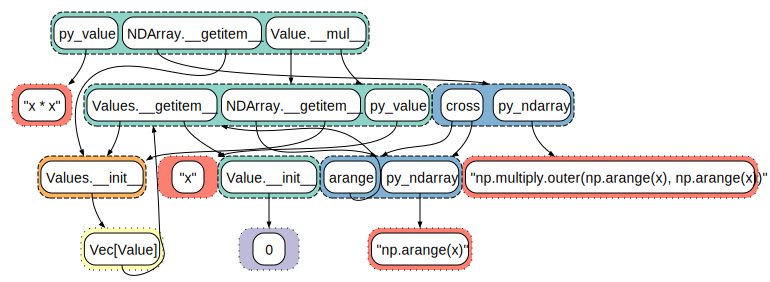

In [28]:
egraph.run(20)
egraph.display()
# egraph.extract(result)

#### Takeaways...
_...from this totally realistic example._

* Declerative nature of `egglog` could facilitate decantralized library collaboration and experimentation.
* Pushing power down, empowering  users and library authors
* Could allow greater collaboration between PL community and data science library community in Python

## Possible next steps?

* Try getting toehold in existing library (like Ibis) to see if constrained egglog approach can still be useful.
    * Add support for Python objects as builtin sort.
* Upstream egglog improvements which could help with reuse
    * First class functions (would help with implementing things like reductions, mapping)
    * User defined generic sorts (i.e. an array type agnostic to inner values)

## Try it out!


```bash
pip install egglog
```

```python
from egglog import *

egraph = EGraph()
...
```

*Come say hello at [github.com/metadsl/egglog-python](https://github.com/metadsl/egglog-python)!*